In [1]:
!pip install eli5
import numpy as np
import pandas as pd 
import matplotlib as plt
import seaborn as sns
import sklearn as sk 
import pyarrow.feather as feather
from sklearn.tree import export_graphviz
from subprocess import call
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
import eli5
from eli5.sklearn import PermutationImportance
RSEED= 42

In [2]:
export_df = feather.read_feather("../data/cleaned_data.feather")

In [3]:
export_df['lenght']=[row.astype(int) for row in export_df['lenght']]

In [4]:
# Function to split the dataset 
def splitdataset(df):

    y=export_df["interesting_message"]
    X=export_df.drop("interesting_message",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2,random_state = 42)
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = splitdataset(export_df) 
    
    

In [7]:
print(X_train.shape)
y_train.shape

(724092, 64)


(724092,)

In [70]:

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'class_weight': ['balanced'],
    'max_depth': [None] + list(np.linspace(0, 50).astype(int)),
    'max_leaf_nodes': list(np.linspace(10, 50, 500).astype(int)),
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, cv = 3, scoring="roc_auc", 
                        n_iter = 12, verbose =1, random_state=RSEED)

# Fit 
rs.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=12, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced'],
                                        'max_depth': [None, 0, 1, 2, 3, 4, 5, 6,
                                                      7, 8, 9, 10, 11, 12, 13,
                                                      14, 15, 16, 17, 18, 19,
                                                      20, 21, 22, 23, 24, 25,
                                                      26, 27, 28, ...],
                                        'max_leaf_nodes': [10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 11, 11,
                                                           11, 11, 11, 11, 11,
                                         

In [71]:
rs.best_params_
best_model = rs.best_estimator_
train_rf_predictions = best_model.predict(X_train)
train_rf_probs = best_model.predict_proba(X_train)[:, 1]

rf_predictions = best_model.predict(X_test)
rf_probs = best_model.predict_proba(X_test)[:, 1]

In [72]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.71 Train: 0.71
Precision Baseline: 0.22 Test: 0.59 Train: 0.59
Roc Baseline: 0.5 Test: 0.84 Train: 0.84


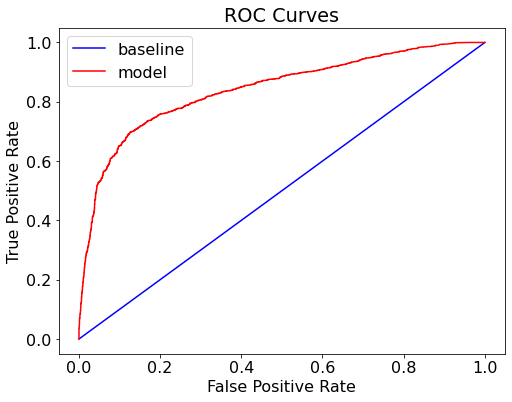

In [73]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [74]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names= X_train.columns , max_depth = 17, 
                class_names = ['reach goal', 'no goal reached'], filled = True)
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=400']); # Convert to png

In [75]:
y_pred = estimator.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred).round()
print("Predicted values:\n", y_pred ) 
print("Confusion Matrix: \n", 
        cm) 
print("Accuracy: %.4f%%" % (accuracy * 100.0))
print(f'Decision tree has {estimator.tree_.node_count} nodes with maximum depth {estimator.tree_.max_depth}.')
print("Report : \n", 
classification_report(y_test, y_pred))

Predicted values:
 [0. 0. 0. ... 1. 1. 0.]
Confusion Matrix: 
 [[98061 42454]
 [11045 29463]]
Accuracy: 70.4463%
Decision tree has 89 nodes with maximum depth 13.
Report : 
               precision    recall  f1-score   support

           0       0.90      0.70      0.79    140515
           1       0.41      0.73      0.52     40508

    accuracy                           0.70    181023
   macro avg       0.65      0.71      0.65    181023
weighted avg       0.79      0.70      0.73    181023



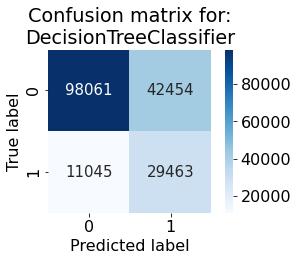

In [76]:
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, annot_kws={"size":15}, 
            cmap='Blues', square=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(estimator.__class__.__name__) );

In [77]:
perm = PermutationImportance(estimator, random_state=1).fit(X_test, y_test)
pd.options.display.max_rows = 100
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0782 ± 0.0017,info_num
0.0639 ± 0.0008,information_sentiment_positive
0.0333 ± 0.0006,information_sentiment_neutral
0.0204 ± 0.0004,cause_Rain
0.0192 ± 0.0003,effect_HighWaitingTime
0.0163 ± 0.0006,effect_SuspensionOfService
0.0157 ± 0.0007,cause_Demonstration
0.0131 ± 0.0006,information_sentiment_negative
0.0121 ± 0.0007,slang_sentiment_neutral
0.0120 ± 0.0005,info_det
